In [2]:
%matplotlib inline
%reset
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skrf as rf # scikit-rf (install using conda -c scikit-rf scikit-rf (or pip))
import sympy # sympy (install using conda -c sympy sympy (or pip))
from sympy import I # imaginary symbol
rf.stylely() # enable scikit-rf plot styles
sympy.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)

# Useful links:
# http://www.qsl.net/in3otd/electronics/Z_fitting/impedance_fitting.html

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
# sympy fun!
x = sympy.symbols('x')
display(sympy.diff(sympy.sin(x) * sympy.exp(x), x))
display(sympy.integrate(sympy.sin(x**2), (x, -sympy.oo, sympy.oo)))
# sympy.subs - expr.subs([(sym1, val1), (sym2, val2)]) WARNING: not very performant use lambdify instead with numpy
# sympy.Eq (sets 2 expressions equal symbolically (dont use ==))
# sympy.simplify (to check symbolic equality: simplify(expr1 - expr2))
# sympy.equals (test expression equality with random numerical evaluation) expr1.equals(expr2)
# sympy.Integer(x) - creates SymPy integer
# sympy.Rational(x,y) - creates symbolic fraction
# sympy.evalf - expr.evalf() - evaluates numerical expression into floating point number
# sympy.lambdify((sym1, sym2, sym3), expr, "numpy") - returns a function

 x           x       
ℯ ⋅sin(x) + ℯ ⋅cos(x)

√2⋅√π
─────
  2  

In [4]:
# Symbolic math helper functions
def ll(a, b): # return a and b in parallel
    return (a * b) / (a + b)

In [78]:
# Characterization of the SMA dummy short (symbolic modeling)
R_sma, L_sma, C_sma, w = sympy.symbols('R_sma L_sma C_sma w', real=True)
L_sma_j = I * w * L_sma
C_sma_j = (I * w * C_sma)**-1
sma_dummy_short_Z11 = sympy.simplify(ll(L_sma_j + R_sma, C_sma_j))
sma_dummy_short_Z11_model = sympy.lambdify((w, C_sma, L_sma, R_sma), sma_dummy_short_Z11, "numpy")
display(sma_dummy_short_Z11)
# Try computing the Jacobian symbolically (it's possible but not worth using it for minimization yet)
display(sympy.simplify(sympy.diff(sympy.ln(sympy.re(sma_dummy_short_Z11)**2 + sympy.im(sma_dummy_short_Z11)**2), R_sma)))

   -ⅈ⋅(ⅈ⋅Lₛₘₐ⋅w + Rₛₘₐ)     
────────────────────────────
Cₛₘₐ⋅w⋅(ⅈ⋅Lₛₘₐ⋅w + Rₛₘₐ) - ⅈ

                                                   ⎛             2    ⎞       
                                           -2⋅Rₛₘₐ⋅⎝2⋅Cₛₘₐ⋅Lₛₘₐ⋅w  - 1⎠       
──────────────────────────────────────────────────────────────────────────────
    2     4  6         2     2     2  4       2     4  2              3  4    
Cₛₘₐ ⋅Lₛₘₐ ⋅w  + 2⋅Cₛₘₐ ⋅Lₛₘₐ ⋅Rₛₘₐ ⋅w  + Cₛₘₐ ⋅Rₛₘₐ ⋅w  - 2⋅Cₛₘₐ⋅Lₛₘₐ ⋅w  - 2

                                      
                                      
──────────────────────────────────────
               2  2       2  2       2
⋅Cₛₘₐ⋅Lₛₘₐ⋅Rₛₘₐ ⋅w  + Lₛₘₐ ⋅w  + Rₛₘₐ 

[2.71e-13, 2.0557e-09, 0.1833]
0.859660381589
[  1.00000000e-12   1.00000000e-09   1.00000000e-01]
0.39031330349
[  1.05000000e-12   1.00000000e-09   1.00000000e-01]
0.422296921602
[  1.00000000e-12   1.05000000e-09   1.00000000e-01]
0.454577448885
[  1.00000000e-12   1.00000000e-09   1.05000000e-01]
0.390125812274
[  1.03333333e-12   9.50000000e-10   1.03333333e-01]
0.352792872884
[  1.05000000e-12   9.00000000e-10   1.05000000e-01]
0.313376945684
[  9.83333333e-13   9.33333333e-10   1.06666667e-01]
0.310353343604
[  9.50000000e-13   9.00000000e-10   1.10000000e-01]
0.268375759181
[  1.00000000e-12   8.66666667e-10   1.13333333e-01]
0.266964640259
[  1.00000000e-12   8.00000000e-10   1.20000000e-01]
0.238333565163
[  1.00000000e-12   7.33333333e-10   1.18333333e-01]
0.237169325741
[  1.00000000e-12   6.00000000e-10   1.25000000e-01]
0.354784921806
[  9.16666667e-13   7.22222222e-10   1.27222222e-01]
0.228343547136
[  8.50000000e-13   6.33333333e-10   1.38333333e-01]
0.320797103092
[  

 final_simplex: (array([[  2.18686057e-14,   1.00761339e-09,   3.31241465e-01],
       [  2.18163456e-14,   1.00763078e-09,   3.31296593e-01],
       [  2.16861386e-14,   1.00767007e-09,   3.31191726e-01],
       [  2.16504226e-14,   1.00766603e-09,   3.31156791e-01]]), array([ 0.02891051,  0.02891051,  0.02891052,  0.02891055]))
           fun: 0.028910508903847321
       message: 'Optimization terminated successfully.'
          nfev: 187
           nit: 106
        status: 0
       success: True
             x: array([  2.18686057e-14,   1.00761339e-09,   3.31241465e-01])

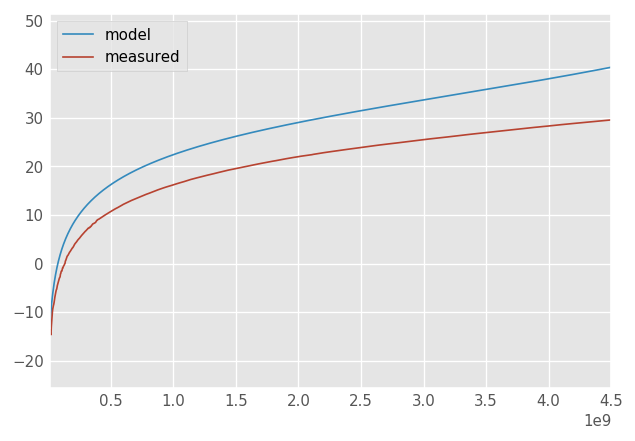

In [109]:
# Characterization of the SMA dummy short (model fitting)
sma_dummy_short_s_params_measured = rf.Network('data/sma_dummy_short_new_cal.S2P')

measured_freqs_omega = sma_dummy_short_s_params_measured.frequency.w 
measured_freqs_f = np.divide(measured_freqs_omega, 2 * np.pi)

measured_S11 =  sma_dummy_short_s_params_measured.s[:,0,0]
measured_Z11 = np.multiply(50, (np.add(1, measured_S11)) / (np.subtract(1, measured_S11)))

def sma_dummy_short_z11_loss_fn(var, plot=False):
    print(var)
    C_sma = np.tile(var[0], len(measured_freqs_f))
    L_sma = np.tile(var[1], len(measured_freqs_f))
    R_sma = np.tile(var[2], len(measured_freqs_f))
    Z11_model = sma_dummy_short_Z11_model(measured_freqs_omega, C_sma, L_sma, R_sma)
    if plot:
        plt.figure()
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(Z11_model)))
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(measured_Z11)))
        plt.legend(['model', 'measured'])
    #MSE = (1.0 / len(measured_freqs_f)) * np.sum(np.square(np.abs(np.subtract(np.log10(Z11_model), np.log10(measured_Z11)))))
    MSE = (1.0 / len(measured_freqs_f)) \
        * np.sum(np.abs(np.subtract(np.log(np.abs(Z11_model)), np.log(np.abs(measured_Z11)))))
    print(MSE)
    return MSE

sma_dummy_short_z11_loss_fn([0.271e-12, 2.0557e-9, 183.3e-3], plot=True)
scipy.optimize.minimize(sma_dummy_short_z11_loss_fn, (1e-12, 1e-9, 100e-3), method='Nelder-Mead', options={'fatol': 0.000001})
#scipy.optimize.minimize(sma_dummy_short_z11_loss_fn, (0.254e-12, 2e-9, 51e-3), \
#                        bounds=((0, 10e-12), (0, 10e-9), (10e-3, 1000e-3)), method='SLSQP', options={'eps':1e-6})
#plt.figure()
#freqs = np.linspace(100e3, 20e9, 1000)
#plt.plot(freqs, 20*np.log10([sma_dummy_short_Z11_model(freq*2*np.pi, 0.254e-12, 2.0877e-9, 51.7e-3) for freq in freqs]))

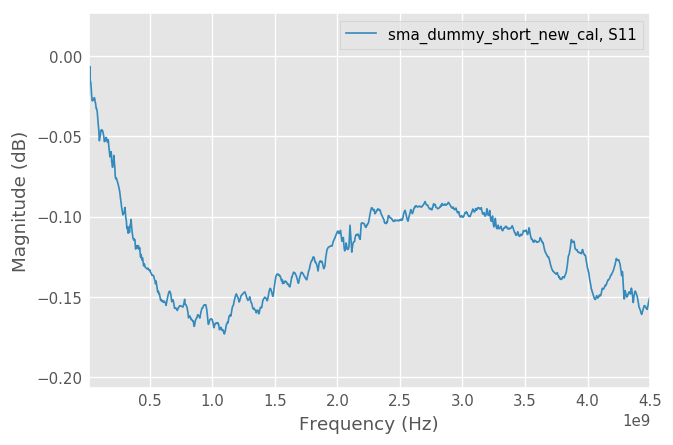

In [108]:
sma_dummy_short_s_params_measured.s11.plot_s_db()
#sma_dummy_short_s_params_measured.s11.plot_s_smith()